In [1]:
# import necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
import os
mypath = os.getcwd()
mypath

'/Users/sarahsobri/Desktop/Face-Mask-Detection-master'

In [3]:
# initialize the initial learning rate, number of epochs to train for and batch size
INIT_LR = 1e-4
EPOCHS =20
BS = 32

DIRECTORY = r'/Users/sarahsobri/Desktop/Face-Mask-Detection-master/dataset'
CATEGORIES = ['with_mask', 'without_mask'] #folders in the directory

In [4]:
#grab the list of images in our dataset directory, then initialize
# the list of data and class images
import os
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

data = [] 
labels =[]

for category in CATEGORIES:
  path = os.path.join(DIRECTORY,category)
  for img in os.listdir(path):
    img_path = os.path.join(path, img)
    image = load_img(img_path, target_size=(224,224)) #height and width of image uniformly converted
    image = img_to_array(image) #convert the image to array
    image = preprocess_input(image) 

    data.append(image) #append image to the data list #the data is now in numerical value
    labels.append(category) #append the category into the labels list #label is still available value. converted

/Users/sarahsobri/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [5]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

In [6]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype='float32')
labels = np.array(labels)

(trainx, testx, trainy, testy) = train_test_split(data,labels,
                                                  test_size=0.2, stratify=labels, random_state=42)

In [7]:
# construct the training iamge generator for data augmentation
# data augmentation- adding various properties. more dataset from one image
aug = ImageDataGenerator( 
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [12]:
from tensorflow.keras.applications import VGG16
BaseModel2 = VGG16(weights='imagenet', include_top=False,
                        input_tensor=Input(shape=(224,224,3)))

In [13]:
for layer in BaseModel2.layers:
    layer.trainable = False # load the weights of VGg16 and freeze them

In [14]:
#construct the head of the model that will be placed on top of the base model

def layer_add(HeadModel2, num_classes):
    HeadModel2 = HeadModel2.output
    HeadModel2 = AveragePooling2D(pool_size=(7,7))(HeadModel2)
    HeadModel2 = Flatten(name='flatten')(HeadModel2)
    HeadModel2 = Dense(128, activation='relu')(HeadModel2)
    HeadModel2 = Dropout(0.5)(HeadModel2)#prevent overfitting
    HeadModel2 = Dense(2, activation='softmax')(HeadModel2)
    return HeadModel2

In [15]:
# set the class number to 2 (mask, without mask)
# add new layers for fine-tuning
num_classes = 2
FC_head = layer_add(BaseModel2, num_classes)

final_model_VGG = Model(inputs = BaseModel2.input, outputs = FC_head)

print(final_model_VGG.summary)

<bound method Model.summary of <tensorflow.python.keras.engine.functional.Functional object at 0x7ff1aa033a60>>


In [22]:
#compile out mode
from tensorflow.keras.callbacks import EarlyStopping

optimizer =Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
final_model_VGG.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])

In [24]:
#train the head of the network
print('[INFO] training head...')
History = final_model_VGG.fit(
    aug.flow(trainx,trainy, batch_size=BS),
    steps_per_epoch=len(trainx) // BS, 
    validation_data=(testx, testy), 
    validation_steps=len(testx) // BS, 
    epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
95/95 [==============================] - 909s 10s/step - loss: 0.7645 - accuracy: 0.5550 - val_loss: 0.5368 - val_accuracy: 0.9022
Epoch 2/20
95/95 [==============================] - 1040s 11s/step - loss: 0.5638 - accuracy: 0.7142 - val_loss: 0.4014 - val_accuracy: 0.9374
Epoch 3/20
95/95 [==============================] - 970s 10s/step - loss: 0.4372 - accuracy: 0.8230 - val_loss: 0.3136 - val_accuracy: 0.9505
Epoch 4/20
95/95 [==============================] - 846s 9s/step - loss: 0.3593 - accuracy: 0.8711 - val_loss: 0.2596 - val_accuracy: 0.9518
Epoch 5/20
95/95 [==============================] - 627s 7s/step - loss: 0.3153 - accuracy: 0.9024 - val_loss: 0.2168 - val_accuracy: 0.9609
Epoch 6/20
95/95 [==============================] - 619s 7s/step - loss: 0.2654 - accuracy: 0.9216 - val_loss: 0.1875 - val_accuracy: 0.9648
Epoch 7/20
95/95 [==============================] - 499s 5s/step - loss: 0.2418 - accuracy: 0.9305 - val_loss: 0.1795 - val_ac

In [27]:
#make predictions on the testing set
predict = final_model_VGG.predict(testx, batch_size=BS)

In [28]:
#for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predict = np.argmax(predict, axis=1)

In [29]:
print(classification_report(testy.argmax(axis=1), predict, target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.98      0.96      0.97       383
without_mask       0.96      0.98      0.97       384

    accuracy                           0.97       767
   macro avg       0.97      0.97      0.97       767
weighted avg       0.97      0.97      0.97       767



In [31]:
# serialize the model to disk
final_model_VGG.save("vgg_mask_detector.model", save_format="h5")

model.save('mask_detector_vgg16.model',save_format='h5)

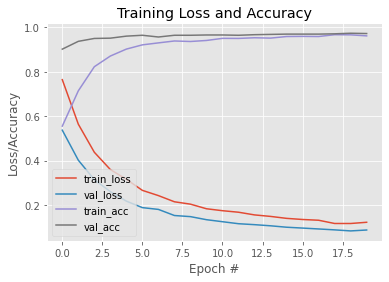

In [35]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), History.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), History.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), History.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), History.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")